<a href="https://colab.research.google.com/github/Malik-Raheel/Trading-Strategies/blob/main/15M4H_volume%2Bvolatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

trend direction 4 hour, and entry exit 15min for volume and volatility

if strong volume and volatility in 4 hour timeframe and then find good positions in 15min timeframe based on RSI EMA 20 50 200
it may check obv and price action in 4H
RSI macd other indicators in 15min for entry exit stoploss.

In [1]:
!pip install --upgrade ccxt pandas numpy scikit-learn tensorflow pandas-ta matplotlib plotly

  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [2]:
import ccxt
import pandas as pd
import numpy as np
import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')

# Initialize exchange
exchange = ccxt.kucoin()

class ImprovedTradingStrategy:
    def __init__(self):
        self.data = {}

    def fetch_data(self, symbol='BTC/USDT', timeframe='1d', limit=300):
        """Fetch OHLCV data from exchange"""
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            return df
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return None

    def calculate_4h_indicators(self, df):
        """Calculate 4H indicators for trend direction with volume + volatility"""
        df = df.copy()

        try:
            # Volume-based Trend Indicators
            df['VWAP'] = ta.vwap(df['high'], df['low'], df['close'], df['volume'])
            df['VWMA_20'] = ta.vwma(df['close'], df['volume'], length=20)
            df['VWMA_50'] = ta.vwma(df['close'], df['volume'], length=50)

            # Volume Momentum
            df['OBV'] = ta.obv(df['close'], df['volume'])
            df['OBV_EMA_20'] = ta.ema(df['OBV'], length=20)

            # Chaikin Money Flow for volume-pressure
            df['CMF_20'] = ta.cmf(df['high'], df['low'], df['close'], df['volume'], length=20)

            # Volatility-adjusted Trend
            df['ATR_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)
            df['EMA_20'] = ta.ema(df['close'], length=20)
            df['EMA_50'] = ta.ema(df['close'], length=50)

            # Supertrend for clear trend direction - FIXED
            supertrend = ta.supertrend(df['high'], df['low'], df['close'], length=10, multiplier=3)
            # Use the actual column names returned by pandas_ta
            if not supertrend.empty:
                supertrend_cols = supertrend.columns
                # Find the correct column names
                for col in supertrend_cols:
                    if 'SUPERT' in col and 'd' not in col:
                        df['Supertrend'] = supertrend[col]
                    elif 'SUPERTd' in col:
                        df['Supertrend_Direction'] = supertrend[col]
            else:
                df['Supertrend'] = np.nan
                df['Supertrend_Direction'] = 0

            # Alternative: Use simpler trend detection if Supertrend fails
            if 'Supertrend' not in df.columns or df['Supertrend'].isna().all():
                df['Supertrend'] = df['EMA_20']
                df['Supertrend_Direction'] = np.where(df['close'] > df['EMA_20'], 1, -1)

            # Trend Strength
            adx_data = ta.adx(df['high'], df['low'], df['close'], length=14)
            if not adx_data.empty:
                df['ADX'] = adx_data['ADX_14']
                df['DMP'] = adx_data['DMP_14'] if 'DMP_14' in adx_data else 0
                df['DMN'] = adx_data['DMN_14'] if 'DMN_14' in adx_data else 0
            else:
                df['ADX'] = 0
                df['DMP'] = 0
                df['DMN'] = 0

            # Volume-based confirmation
            df['Volume_SMA_20'] = ta.sma(df['volume'], length=20)
            df['Volume_Ratio'] = df['volume'] / df['Volume_SMA_20']

            # Fill NaN values
            df = df.fillna(method='bfill').fillna(method='ffill')

        except Exception as e:
            print(f"Error calculating 4H indicators: {e}")
            # Add fallback indicators
            df['EMA_20'] = ta.ema(df['close'], length=20)
            df['EMA_50'] = ta.ema(df['close'], length=50)
            df['VWMA_20'] = df['EMA_20']
            df['VWMA_50'] = df['EMA_50']
            df['Supertrend_Direction'] = np.where(df['close'] > df['EMA_20'], 1, -1)
            df['ADX'] = 25
            df['Volume_Ratio'] = 1.0

        return df

    def calculate_15m_indicators(self, df):
        """Calculate 15M indicators for precise entries"""
        df = df.copy()

        try:
            # Momentum Indicators
            df['RSI_14'] = ta.rsi(df['close'], length=14)

            # MACD for momentum
            macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
            if not macd.empty:
                df['MACD'] = macd['MACD_12_26_9']
                df['MACD_signal'] = macd['MACDs_12_26_9']
                df['MACD_histogram'] = macd['MACDh_12_26_9']
            else:
                df['MACD'] = 0
                df['MACD_signal'] = 0
                df['MACD_histogram'] = 0

            # Volatility for stops
            df['ATR_5'] = ta.atr(df['high'], df['low'], df['close'], length=5)

            # Volume confirmation
            df['Volume_EMA_10'] = ta.ema(df['volume'], length=10)
            df['Volume_Spike'] = df['volume'] > (df['Volume_EMA_10'] * 1.2)

            # Price action
            df['EMA_9'] = ta.ema(df['close'], length=9)
            df['EMA_21'] = ta.ema(df['close'], length=21)

            # Fill NaN values
            df = df.fillna(method='bfill').fillna(method='ffill')

        except Exception as e:
            print(f"Error calculating 15M indicators: {e}")
            # Fallback values
            df['RSI_14'] = 50
            df['MACD'] = 0
            df['MACD_signal'] = 0
            df['MACD_histogram'] = 0
            df['ATR_5'] = df['close'] * 0.01
            df['Volume_Spike'] = False
            df['EMA_9'] = df['close']
            df['EMA_21'] = df['close']

        return df

    def identify_4h_trend(self, df_4h):
        """Step 1: Identify 4H Trend Direction using Volume + Volatility"""
        if len(df_4h) < 3:
            return 'neutral'

        try:
            current = df_4h.iloc[-1]
            prev = df_4h.iloc[-2]

            # Volume-Weighted Bullish Trend
            volume_bullish = (
                current['VWMA_20'] > current['VWMA_50'] and      # Volume-weighted uptrend
                current['OBV'] > current['OBV_EMA_20'] and       # OBV rising
                current['CMF_20'] > 0 and                        # Money flow positive
                current['Volume_Ratio'] > 0.8                    # Healthy volume
            )

            # Volume-Weighted Bearish Trend
            volume_bearish = (
                current['VWMA_20'] < current['VWMA_50'] and      # Volume-weighted downtrend
                current['OBV'] < current['OBV_EMA_20'] and       # OBV falling
                current['CMF_20'] < 0 and                        # Money flow negative
                current['Volume_Ratio'] > 0.8                    # Healthy volume
            )

            # Trend Strength Filter
            strong_trend = current['ADX'] > 25
            moderate_trend = current['ADX'] > 20

            # Supertrend confirmation
            supertrend_bullish = current.get('Supertrend_Direction', 0) == 1
            supertrend_bearish = current.get('Supertrend_Direction', 0) == -1

            # Final Trend Classification with multiple confirmations
            bullish_conditions = [
                volume_bullish,
                supertrend_bullish,
                moderate_trend,
                current['close'] > current['VWMA_20']
            ]

            bearish_conditions = [
                volume_bearish,
                supertrend_bearish,
                moderate_trend,
                current['close'] < current['VWMA_20']
            ]

            bullish_score = sum(bullish_conditions)
            bearish_score = sum(bearish_conditions)

            if bullish_score >= 3 and strong_trend:
                return 'strong_bullish'
            elif bullish_score >= 3:
                return 'bullish'
            elif bearish_score >= 3 and strong_trend:
                return 'strong_bearish'
            elif bearish_score >= 3:
                return 'bearish'
            else:
                return 'neutral'

        except Exception as e:
            print(f"Error identifying 4H trend: {e}")
            return 'neutral'

    def get_15m_entry_signals(self, df_15m, trend_direction):
        """Step 2: Find 15M Entry Signals with RSI + MACD"""
        if len(df_15m) < 3:
            return [], []

        try:
            current = df_15m.iloc[-1]
            prev = df_15m.iloc[-2]
            prev2 = df_15m.iloc[-3]

            signals = []
            trade_details = []

            # Dynamic RSI levels based on trend strength
            if 'strong' in trend_direction:
                rsi_oversold = 45
                rsi_overbought = 75
            else:
                rsi_oversold = 35
                rsi_overbought = 65

            if trend_direction in ['bullish', 'strong_bullish']:
                # Long Entry Conditions with multiple confirmations
                long_conditions = [
                    current['RSI_14'] > rsi_oversold,                    # Not oversold
                    current['RSI_14'] < rsi_overbought,                  # Not overbought
                    current['MACD'] > current['MACD_signal'],            # MACD bullish
                    current['MACD_histogram'] > prev['MACD_histogram'],  # MACD improving
                    current['close'] > current['EMA_9'],                 # Above fast EMA
                    current['EMA_9'] > current['EMA_21'],                # EMA bullish alignment
                    current.get('Volume_Spike', False),                  # Volume confirmation
                    current['RSI_14'] > 50 or trend_direction == 'strong_bullish'  # Momentum
                ]

                conditions_met = sum(long_conditions)

                # Require more confirmations in weaker trends
                min_conditions = 7 if trend_direction == 'strong_bullish' else 6

                if conditions_met >= min_conditions:
                    # Volatility-adjusted position sizing
                    atr = current.get('ATR_5', current['close'] * 0.01)
                    entry_price = current['close']

                    # Tighter stops in strong trends, wider in weak trends
                    stop_multiplier = 1.0 if 'strong' in trend_direction else 1.5
                    tp_multiplier = 3.0 if 'strong' in trend_direction else 2.5

                    stop_loss = entry_price - (stop_multiplier * atr)
                    take_profit = entry_price + (tp_multiplier * atr)

                    grade = self.grade_setup(conditions_met, len(long_conditions), trend_direction)

                    signals.append('LONG')
                    trade_details.append({
                        'type': 'LONG',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'grade': grade,
                        'conditions_met': f"{conditions_met}/{len(long_conditions)}",
                        'risk_reward': tp_multiplier / stop_multiplier,
                        'timeframe': '15M'
                    })

            elif trend_direction in ['bearish', 'strong_bearish']:
                # Short Entry Conditions
                short_conditions = [
                    current['RSI_14'] < rsi_overbought,                  # Not overbought
                    current['RSI_14'] > rsi_oversold,                    # Not oversold
                    current['MACD'] < current['MACD_signal'],            # MACD bearish
                    current['MACD_histogram'] < prev['MACD_histogram'],  # MACD deteriorating
                    current['close'] < current['EMA_9'],                 # Below fast EMA
                    current['EMA_9'] < current['EMA_21'],                # EMA bearish alignment
                    current.get('Volume_Spike', False),                  # Volume confirmation
                    current['RSI_14'] < 50 or trend_direction == 'strong_bearish'  # Momentum
                ]

                conditions_met = sum(short_conditions)

                min_conditions = 7 if trend_direction == 'strong_bearish' else 6

                if conditions_met >= min_conditions:
                    atr = current.get('ATR_5', current['close'] * 0.01)
                    entry_price = current['close']

                    stop_multiplier = 1.0 if 'strong' in trend_direction else 1.5
                    tp_multiplier = 3.0 if 'strong' in trend_direction else 2.5

                    stop_loss = entry_price + (stop_multiplier * atr)
                    take_profit = entry_price - (tp_multiplier * atr)

                    grade = self.grade_setup(conditions_met, len(short_conditions), trend_direction)

                    signals.append('SHORT')
                    trade_details.append({
                        'type': 'SHORT',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'grade': grade,
                        'conditions_met': f"{conditions_met}/{len(short_conditions)}",
                        'risk_reward': tp_multiplier / stop_multiplier,
                        'timeframe': '15M'
                    })

            return signals, trade_details

        except Exception as e:
            print(f"Error getting 15M signals: {e}")
            return [], []

    def grade_setup(self, conditions_met, total_conditions, trend):
        """Grade trade setup from A+ to C"""
        try:
            score = (conditions_met / total_conditions) * 100

            # Higher grading for strong trends
            if 'strong' in trend:
                score += 10

            if score >= 90:
                return 'A+'
            elif score >= 80:
                return 'A'
            elif score >= 70:
                return 'B+'
            elif score >= 60:
                return 'B'
            elif score >= 50:
                return 'C+'
            else:
                return 'C'
        except:
            return 'C'

    def calculate_position_size(self, capital, entry_price, stop_loss, volatility_ratio=1.0):
        """Calculate position size with volatility adjustment"""
        try:
            risk_per_trade = 0.02  # 2% risk
            risk_amount = capital * risk_per_trade

            # Adjust risk based on volatility (lower risk in high volatility)
            volatility_adjustment = min(1.0, 1.0 / max(volatility_ratio, 0.1))
            adjusted_risk = risk_amount * volatility_adjustment

            price_diff = abs(entry_price - stop_loss)

            if price_diff == 0:
                return 0

            position_size = adjusted_risk / price_diff
            return min(position_size, capital / entry_price * 0.95)  # 95% of capital max
        except:
            return 0

    def analyze_symbol(self, symbol='BTC/USDT', capital=1000):
        """Complete analysis for a symbol"""
        print(f"\n{'='*80}")
        print(f"🎯 IMPROVED TRADING ANALYSIS: {symbol}")
        print(f"{'='*80}")

        try:
            # Fetch 4H data for trend analysis
            df_4h = self.fetch_data(symbol, '4h')
            if df_4h is None or df_4h.empty:
                print(f"❌ Could not fetch 4H data for {symbol}")
                return

            df_4h = self.calculate_4h_indicators(df_4h)
            trend_4h = self.identify_4h_trend(df_4h)

            # Fetch 15M data for entry signals
            df_15m = self.fetch_data(symbol, '15m')
            if df_15m is None or df_15m.empty:
                print(f"❌ Could not fetch 15M data for {symbol}")
                return

            df_15m = self.calculate_15m_indicators(df_15m)
            signals, trade_details = self.get_15m_entry_signals(df_15m, trend_4h)

            current_4h = df_4h.iloc[-1]
            current_15m = df_15m.iloc[-1]

            # Display 4H Trend Analysis
            trend_icon = "🟢" if 'bullish' in trend_4h else "🔴" if 'bearish' in trend_4h else "⚪"
            strength_icon = "💪" if 'strong' in trend_4h else "🔄"
            print(f"\n📈 4H TREND ANALYSIS: {trend_icon} {trend_4h.upper().replace('_', ' ')} {strength_icon}")
            print(f"   • Price: ${current_4h['close']:.2f}")
            print(f"   • VWMA20: ${current_4h.get('VWMA_20', 0):.2f} | VWMA50: ${current_4h.get('VWMA_50', 0):.2f}")
            print(f"   • OBV: {current_4h.get('OBV', 0):.0f} | CMF: {current_4h.get('CMF_20', 0):.3f}")
            print(f"   • Supertrend: {'Bullish' if current_4h.get('Supertrend_Direction', 0) == 1 else 'Bearish'}")
            print(f"   • ADX: {current_4h.get('ADX', 0):.1f} | ATR: ${current_4h.get('ATR_14', 0):.2f}")
            print(f"   • Volume Ratio: {current_4h.get('Volume_Ratio', 0):.2f}x")

            # Display 15M Indicators
            print(f"\n📊 15M ENTRY INDICATORS:")
            print(f"   • Price: ${current_15m['close']:.2f}")
            print(f"   • RSI(14): {current_15m.get('RSI_14', 50):.1f}")
            print(f"   • MACD: {current_15m.get('MACD', 0):.4f} | Signal: {current_15m.get('MACD_signal', 0):.4f}")
            print(f"   • EMA9: ${current_15m.get('EMA_9', 0):.2f} | EMA21: ${current_15m.get('EMA_21', 0):.2f}")
            print(f"   • ATR(5): ${current_15m.get('ATR_5', 0):.4f} | Volume Spike: {'Yes' if current_15m.get('Volume_Spike', False) else 'No'}")

            # Display Signals
            if signals:
                for trade in trade_details:
                    trend_strength = "STRONG" if "strong" in trend_4h else "MODERATE"
                    print(f"\n🎯 {trend_strength} {trade['type']} SIGNAL - GRADE: {trade['grade']}")
                    print(f"   📍 Entry: ${trade['entry_price']:.2f}")
                    print(f"   🛑 Stop Loss: ${trade['stop_loss']:.2f}")
                    print(f"   🎯 Take Profit: ${trade['take_profit']:.2f}")
                    print(f"   ⚖️ Risk/Reward: 1:{trade['risk_reward']:.1f}")
                    print(f"   📋 Conditions Met: {trade['conditions_met']}")

                    # Volatility-adjusted position sizing
                    volatility_ratio = current_4h.get('ATR_14', 0) / max(current_4h['close'], 1)
                    position_size = self.calculate_position_size(capital, trade['entry_price'], trade['stop_loss'], volatility_ratio)
                    risk_amount = abs(trade['entry_price'] - trade['stop_loss']) * position_size
                    potential_profit = abs(trade['take_profit'] - trade['entry_price']) * position_size

                    print(f"   💰 Position Size: {position_size:.6f} {symbol.split('/')[0]}")
                    print(f"   📈 Risk: ${risk_amount:.2f} | Reward: ${potential_profit:.2f}")

                    # Enhanced trade advice
                    if trade['grade'] in ['A+', 'A']:
                        print(f"   💡 ADVICE: HIGH-QUALITY SETUP - Consider entering with full position")
                    elif trade['grade'] in ['B+', 'B']:
                        print(f"   💡 ADVICE: GOOD SETUP - Enter with half position, add on confirmation")
                    else:
                        print(f"   💡 ADVICE: MODERATE SETUP - Wait for price action confirmation")

                    # Additional context
                    if 'strong' in trend_4h:
                        print(f"   🔥 TREND CONTEXT: Strong trend - Higher probability setup")
                    else:
                        print(f"   ⚠️  TREND CONTEXT: Moderate trend - Manage position size carefully")
            else:
                print(f"\n❌ NO TRADE SIGNALS")
                if trend_4h == 'neutral':
                    print(f"   💡 Reason: 4H trend is neutral - Wait for clear direction")
                else:
                    print(f"   💡 Reason: 15M conditions not met for {trend_4h} trend")
                    print(f"   🔄 Suggestion: Wait for RSI between 40-60 and MACD crossover with volume")

            print(f"\n{'='*80}")

        except Exception as e:
            print(f"❌ Error analyzing {symbol}: {e}")
            print(f"{'='*80}")

# Main execution
def main():
    strategy = ImprovedTradingStrategy()

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'AVAX/USDT', 'LINK/USDT', 'HNT/USDT']
    capital = 1000

    print("🚀 IMPROVED CRYPTO TRADING STRATEGY - 4H TREND + 15M ENTRIES")
    print("=" * 80)
    print("STRATEGY ENHANCEMENTS:")
    print("• 4H Trend: VWMA + OBV + CMF + Supertrend + ADX for volume-weighted trends")
    print("• 15M Entries: RSI + MACD + Volume Spike + EMA alignment")
    print("• Dynamic Stops: 1.0-1.5×ATR | TP: 2.5-3.0×ATR based on trend strength")
    print("• Volatility-adjusted position sizing")
    print("• Strong trend filter to avoid counter-trend longs in downtrends")
    print("=" * 80)

    for symbol in symbols:
        try:
            strategy.analyze_symbol(symbol, capital)
        except Exception as e:
            print(f"❌ Failed to analyze {symbol}: {e}")
            continue

if __name__ == "__main__":
    main()

🚀 IMPROVED CRYPTO TRADING STRATEGY - 4H TREND + 15M ENTRIES
STRATEGY ENHANCEMENTS:
• 4H Trend: VWMA + OBV + CMF + Supertrend + ADX for volume-weighted trends
• 15M Entries: RSI + MACD + Volume Spike + EMA alignment
• Dynamic Stops: 1.0-1.5×ATR | TP: 2.5-3.0×ATR based on trend strength
• Volatility-adjusted position sizing
• Strong trend filter to avoid counter-trend longs in downtrends

🎯 IMPROVED TRADING ANALYSIS: BTC/USDT

📈 4H TREND ANALYSIS: ⚪ NEUTRAL 🔄
   • Price: $111465.70
   • VWMA20: $109241.30 | VWMA50: $108697.05
   • OBV: -5280 | CMF: 0.034
   • Supertrend: Bullish
   • ADX: 15.8 | ATR: $1259.34
   • Volume Ratio: 0.28x

📊 15M ENTRY INDICATORS:
   • Price: $111465.70
   • RSI(14): 50.9
   • MACD: 94.2500 | Signal: 130.3110
   • EMA9: $111550.11 | EMA21: $111490.98
   • ATR(5): $150.6058 | Volume Spike: No

❌ NO TRADE SIGNALS
   💡 Reason: 4H trend is neutral - Wait for clear direction


🎯 IMPROVED TRADING ANALYSIS: ETH/USDT

📈 4H TREND ANALYSIS: ⚪ NEUTRAL 🔄
   • Price: $3935

backtest results below

🚀 COMPLETE MULTI-ASSET BACKTEST ANALYSIS
STRATEGY: 4H Trend + 15M Entries | Volume + Volatility + RSI + MACD

##################################################
ANALYZING 1/6: BTC/USDT
##################################################

🔬 BACKTESTING: BTC/USDT

📊 BACKTEST RESULTS: BTC/USDT
   • Period: 6 trades analyzed
   • Initial Capital: $1,000.00
   • Final Capital: $997.41
   • Total P&L: $-2.59 (-0.3%)

📈 PERFORMANCE METRICS:
   • Win Rate: 33.3%
   • Profit Factor: 0.78
   • Sharpe Ratio: -0.12
   • Max Drawdown: -0.9%
   • Avg P&L per Trade: $-0.43

🎯 LONG/SHORT BREAKDOWN:
   📈 LONG Trades: 3
     • Win Rate: 33.3%
     • Wins: 1 | Losses: 2
     • Total P&L: $-2.52
     • Avg P&L: $-0.84
   📉 SHORT Trades: 3
     • Win Rate: 33.3%
     • Wins: 1 | Losses: 2
     • Total P&L: $-0.07
     • Avg P&L: $-0.02

📊 OUTCOME DISTRIBUTION:
   • Take Profit: 2 trades
   • Stop Loss: 4 trades
   • Time Exit: 0 trades

⭐ GRADE PERFORMANCE:
   • A+: 5 trades, 20.0% win rate, $-1.55 avg
   •

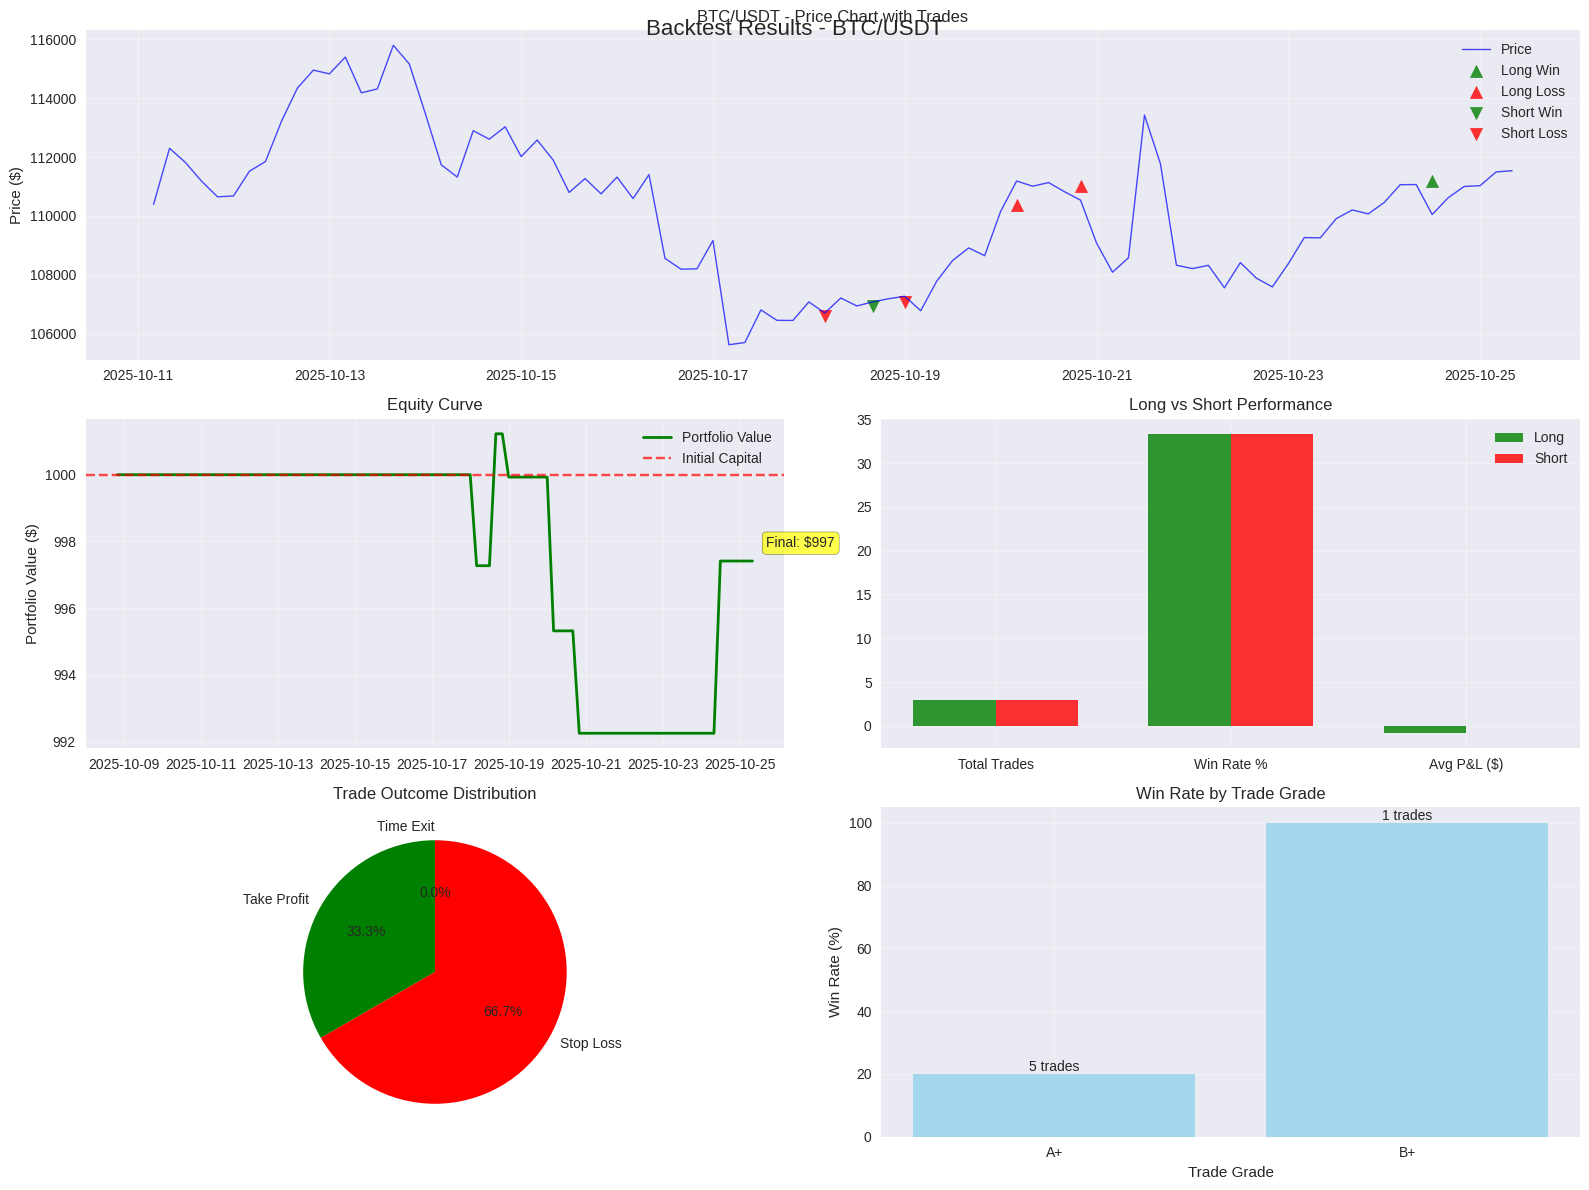


##################################################
ANALYZING 2/6: ETH/USDT
##################################################

🔬 BACKTESTING: ETH/USDT

📊 BACKTEST RESULTS: ETH/USDT
   • Period: 2 trades analyzed
   • Initial Capital: $1,000.00
   • Final Capital: $991.70
   • Total P&L: $-8.30 (-0.8%)

📈 PERFORMANCE METRICS:
   • Win Rate: 0.0%
   • Profit Factor: 0.00
   • Sharpe Ratio: -4.90
   • Max Drawdown: -0.8%
   • Avg P&L per Trade: $-4.15

🎯 LONG/SHORT BREAKDOWN:
   📈 LONG Trades: 0
     • Win Rate: 0.0%
     • Wins: 0 | Losses: 0
     • Total P&L: $0.00
     • Avg P&L: $0.00
   📉 SHORT Trades: 2
     • Win Rate: 0.0%
     • Wins: 0 | Losses: 2
     • Total P&L: $-8.30
     • Avg P&L: $-4.15

📊 OUTCOME DISTRIBUTION:
   • Take Profit: 0 trades
   • Stop Loss: 2 trades
   • Time Exit: 0 trades

⭐ GRADE PERFORMANCE:
   • A+: 1 trades, 0.0% win rate, $-3.31 avg
   • B+: 1 trades, 0.0% win rate, $-4.99 avg


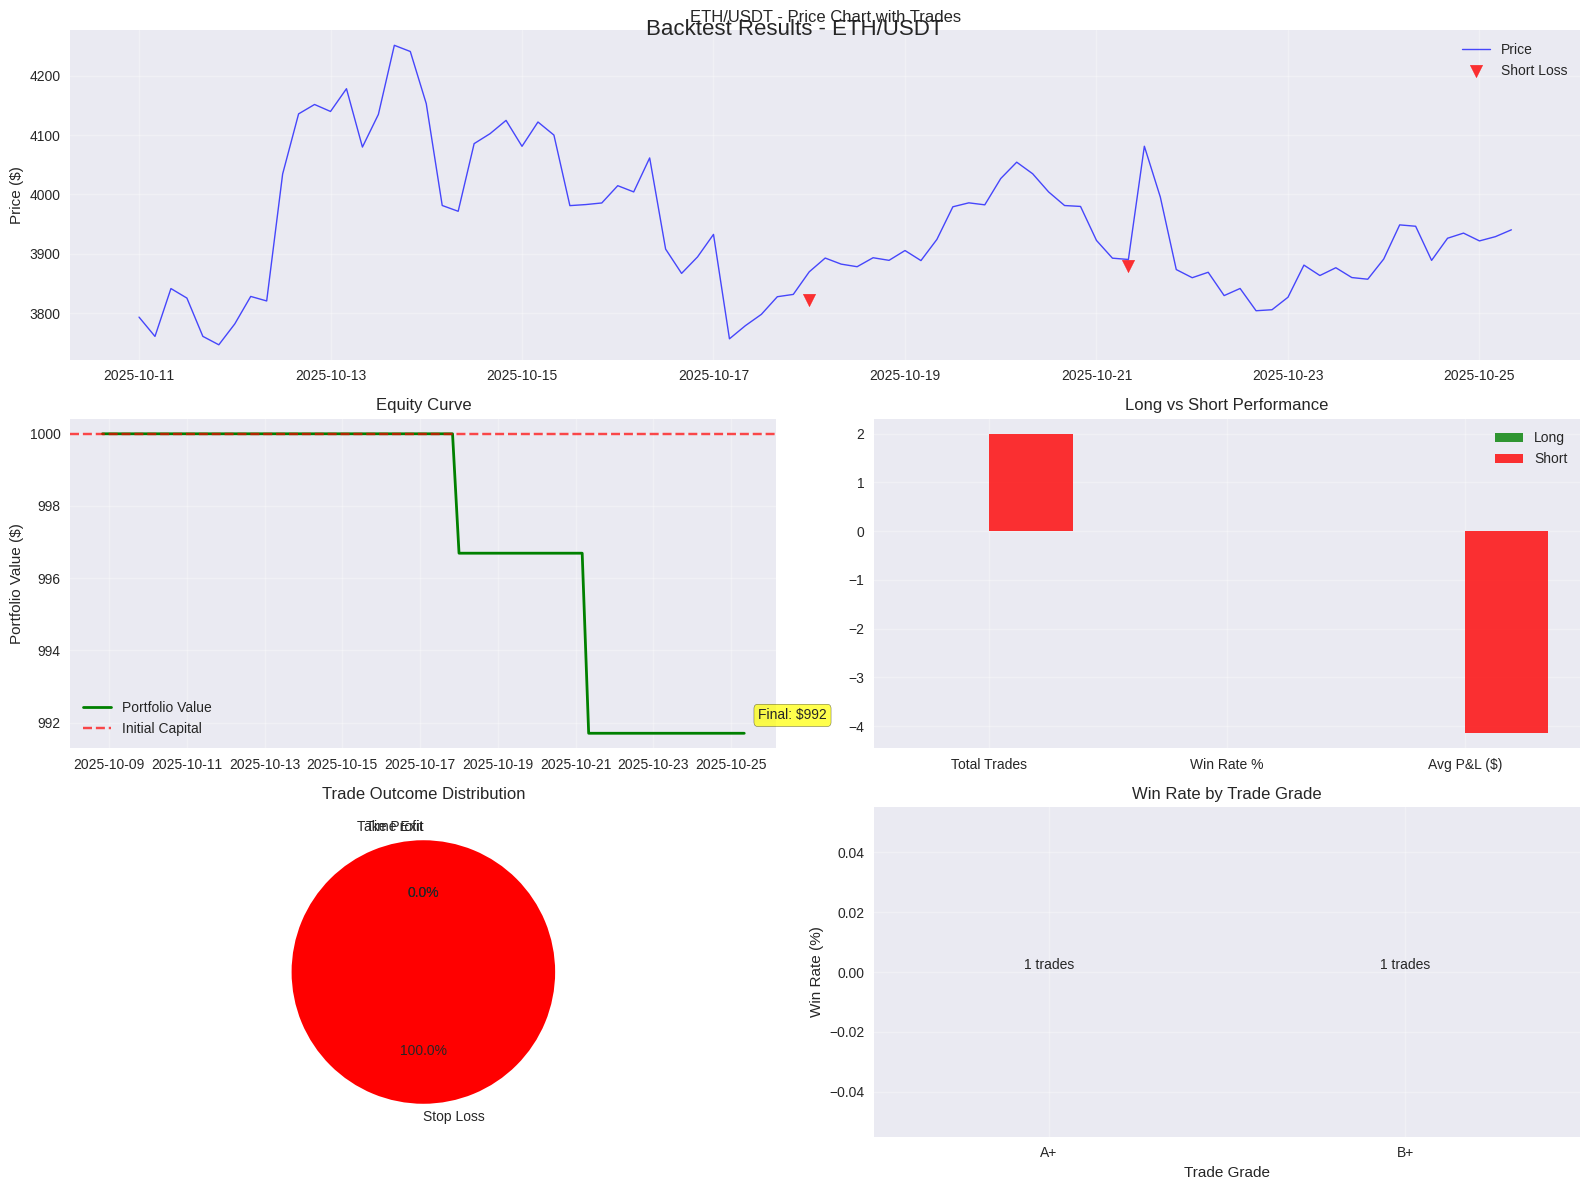


##################################################
ANALYZING 3/6: ADA/USDT
##################################################

🔬 BACKTESTING: ADA/USDT

📊 BACKTEST RESULTS: ADA/USDT
   • Period: 5 trades analyzed
   • Initial Capital: $1,000.00
   • Final Capital: $977.92
   • Total P&L: $-22.08 (-2.2%)

📈 PERFORMANCE METRICS:
   • Win Rate: 0.0%
   • Profit Factor: 0.00
   • Sharpe Ratio: -3.25
   • Max Drawdown: -2.2%
   • Avg P&L per Trade: $-4.42

🎯 LONG/SHORT BREAKDOWN:
   📈 LONG Trades: 0
     • Win Rate: 0.0%
     • Wins: 0 | Losses: 0
     • Total P&L: $0.00
     • Avg P&L: $0.00
   📉 SHORT Trades: 5
     • Win Rate: 0.0%
     • Wins: 0 | Losses: 5
     • Total P&L: $-22.08
     • Avg P&L: $-4.42

📊 OUTCOME DISTRIBUTION:
   • Take Profit: 0 trades
   • Stop Loss: 5 trades
   • Time Exit: 0 trades

⭐ GRADE PERFORMANCE:
   • A+: 5 trades, 0.0% win rate, $-4.42 avg


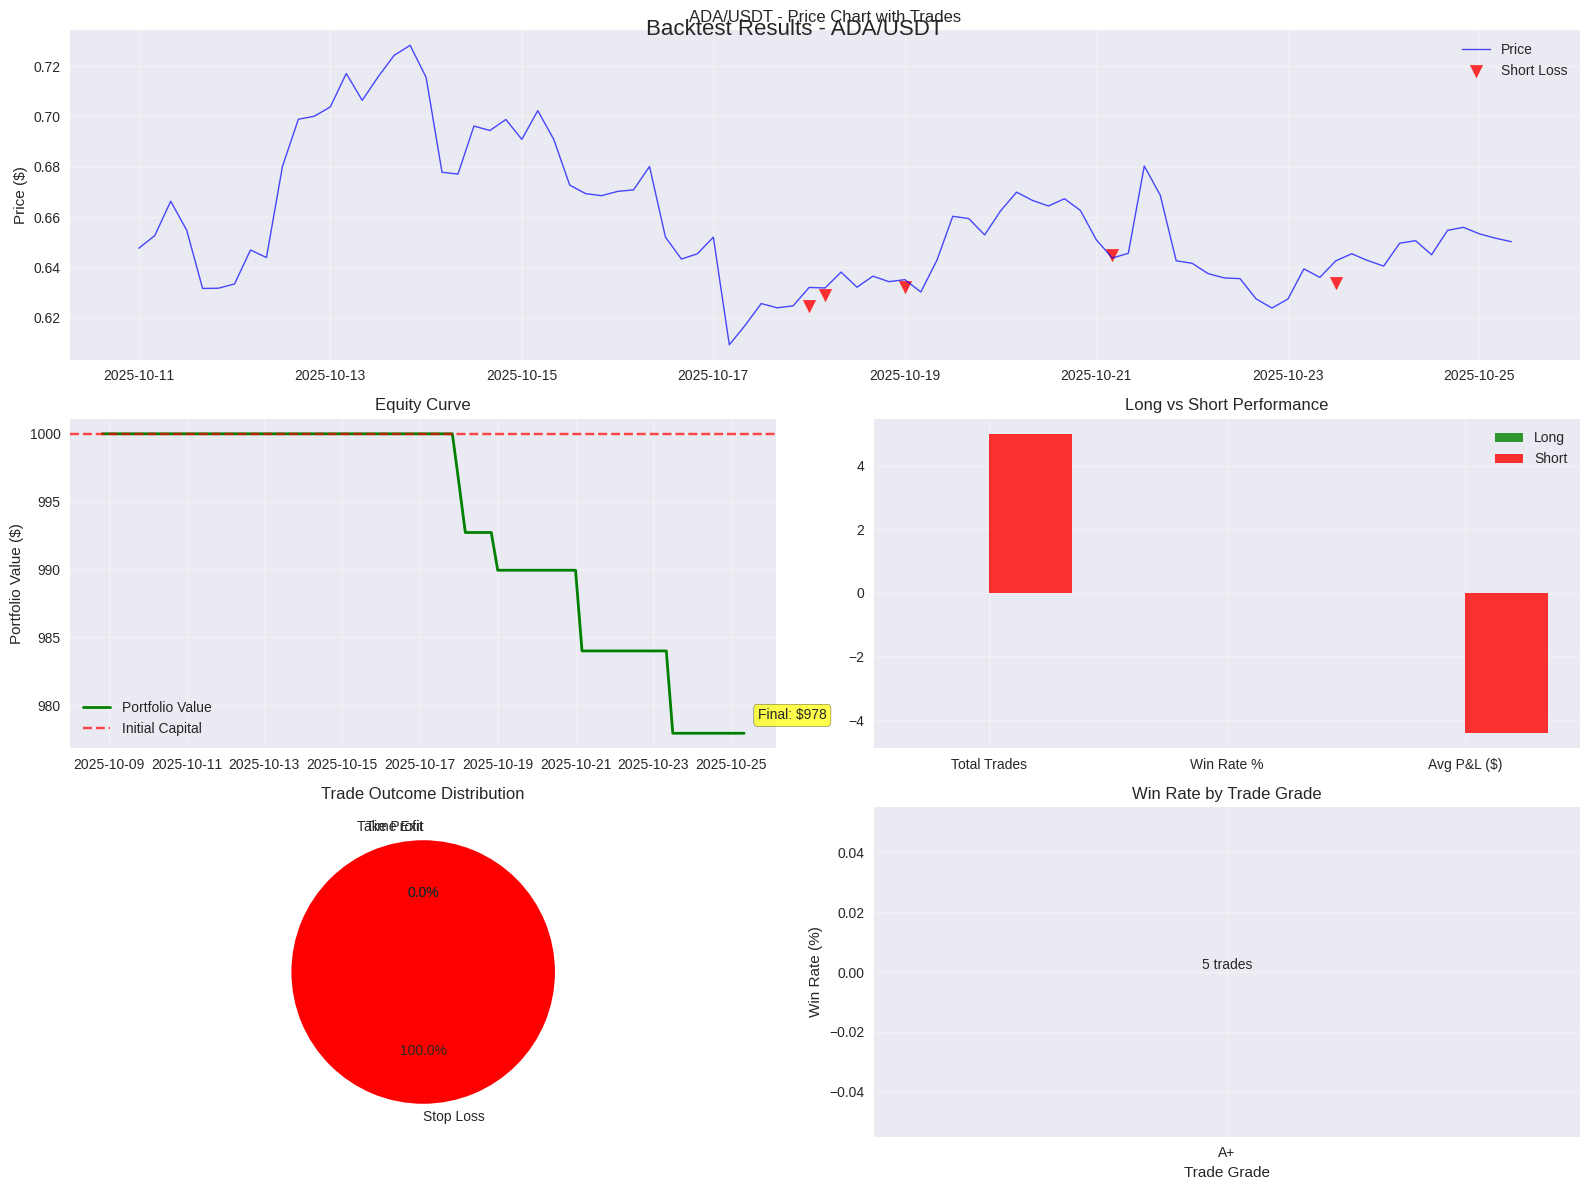


##################################################
ANALYZING 4/6: AVAX/USDT
##################################################

🔬 BACKTESTING: AVAX/USDT

📊 BACKTEST RESULTS: AVAX/USDT
   • Period: 6 trades analyzed
   • Initial Capital: $1,000.00
   • Final Capital: $1,042.89
   • Total P&L: $42.89 (4.3%)

📈 PERFORMANCE METRICS:
   • Win Rate: 50.0%
   • Profit Factor: 4.32
   • Sharpe Ratio: 0.61
   • Max Drawdown: -0.9%
   • Avg P&L per Trade: $7.15

🎯 LONG/SHORT BREAKDOWN:
   📈 LONG Trades: 0
     • Win Rate: 0.0%
     • Wins: 0 | Losses: 0
     • Total P&L: $0.00
     • Avg P&L: $0.00
   📉 SHORT Trades: 6
     • Win Rate: 50.0%
     • Wins: 3 | Losses: 3
     • Total P&L: $42.89
     • Avg P&L: $7.15

📊 OUTCOME DISTRIBUTION:
   • Take Profit: 3 trades
   • Stop Loss: 3 trades
   • Time Exit: 0 trades

⭐ GRADE PERFORMANCE:
   • A+: 6 trades, 50.0% win rate, $7.15 avg


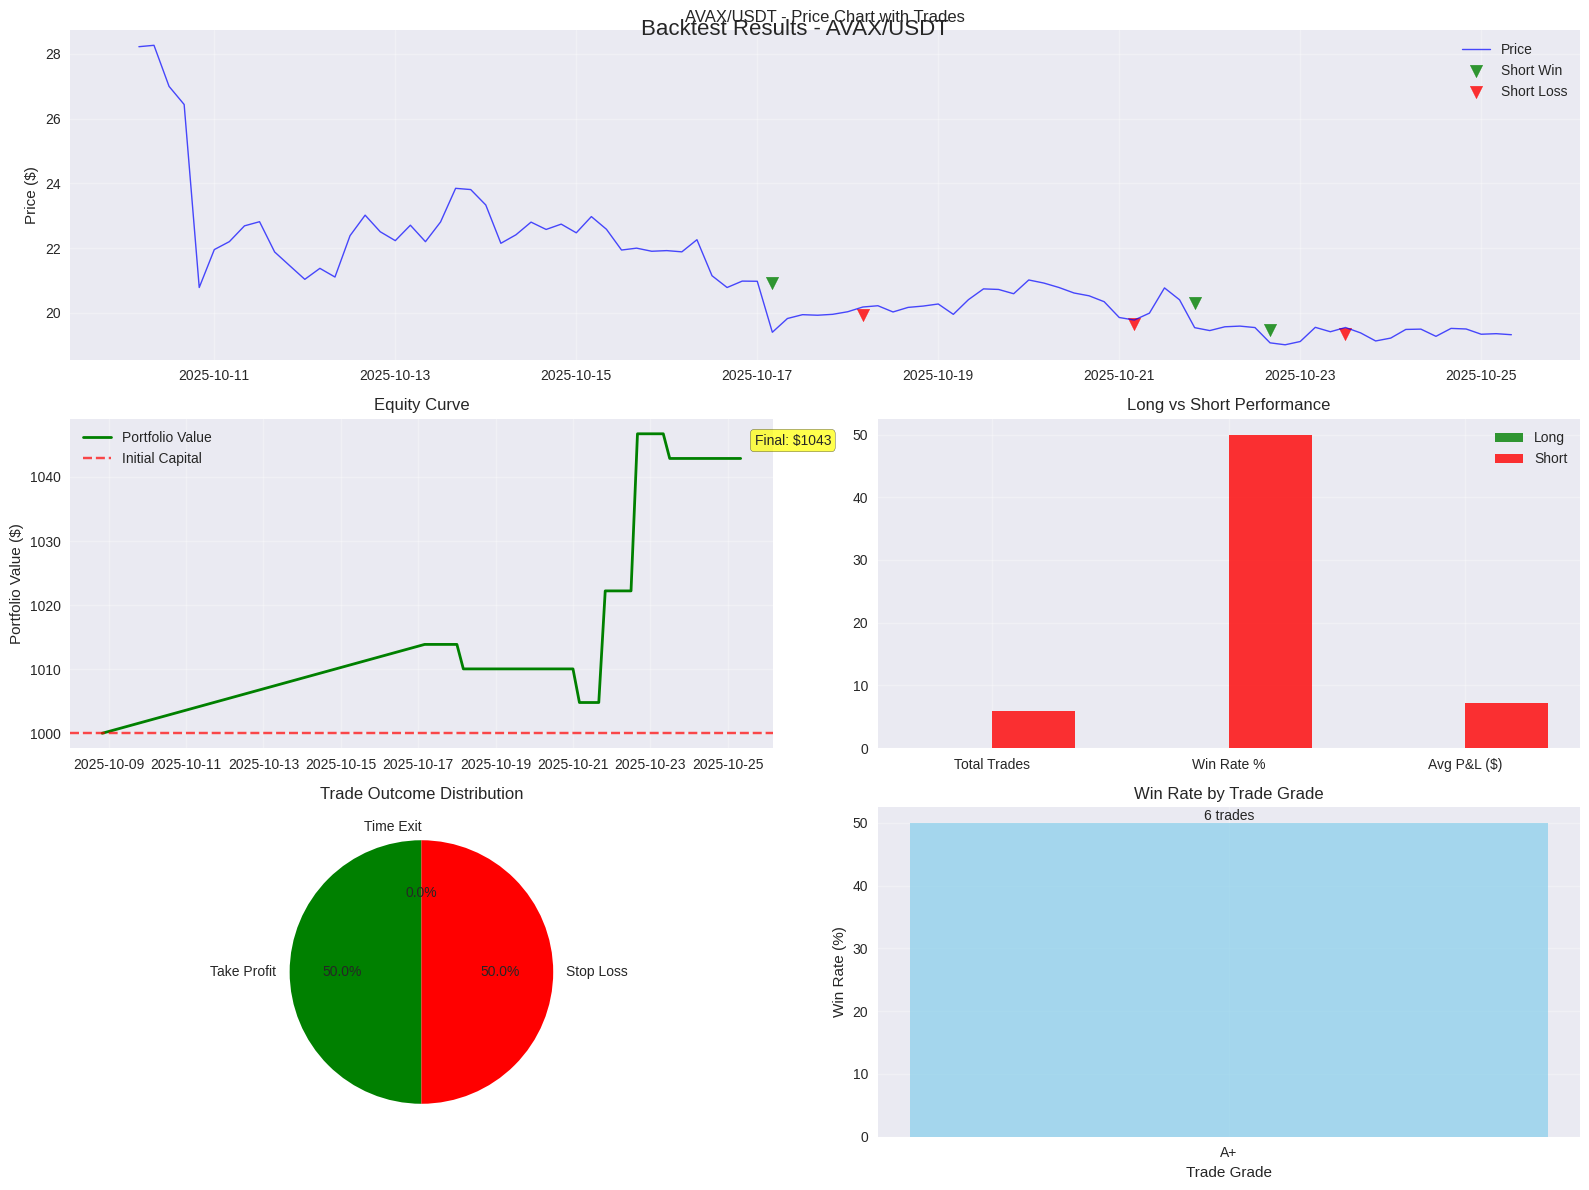


##################################################
ANALYZING 5/6: LINK/USDT
##################################################

🔬 BACKTESTING: LINK/USDT

📊 BACKTEST RESULTS: LINK/USDT
   • Period: 5 trades analyzed
   • Initial Capital: $1,000.00
   • Final Capital: $1,002.22
   • Total P&L: $2.22 (0.2%)

📈 PERFORMANCE METRICS:
   • Win Rate: 20.0%
   • Profit Factor: 1.10
   • Sharpe Ratio: 0.04
   • Max Drawdown: -1.3%
   • Avg P&L per Trade: $0.44

🎯 LONG/SHORT BREAKDOWN:
   📈 LONG Trades: 3
     • Win Rate: 33.3%
     • Wins: 1 | Losses: 2
     • Total P&L: $10.58
     • Avg P&L: $3.53
   📉 SHORT Trades: 2
     • Win Rate: 0.0%
     • Wins: 0 | Losses: 2
     • Total P&L: $-8.36
     • Avg P&L: $-4.18

📊 OUTCOME DISTRIBUTION:
   • Take Profit: 1 trades
   • Stop Loss: 4 trades
   • Time Exit: 0 trades

⭐ GRADE PERFORMANCE:
   • A+: 4 trades, 25.0% win rate, $2.59 avg
   • B+: 1 trades, 0.0% win rate, $-8.13 avg


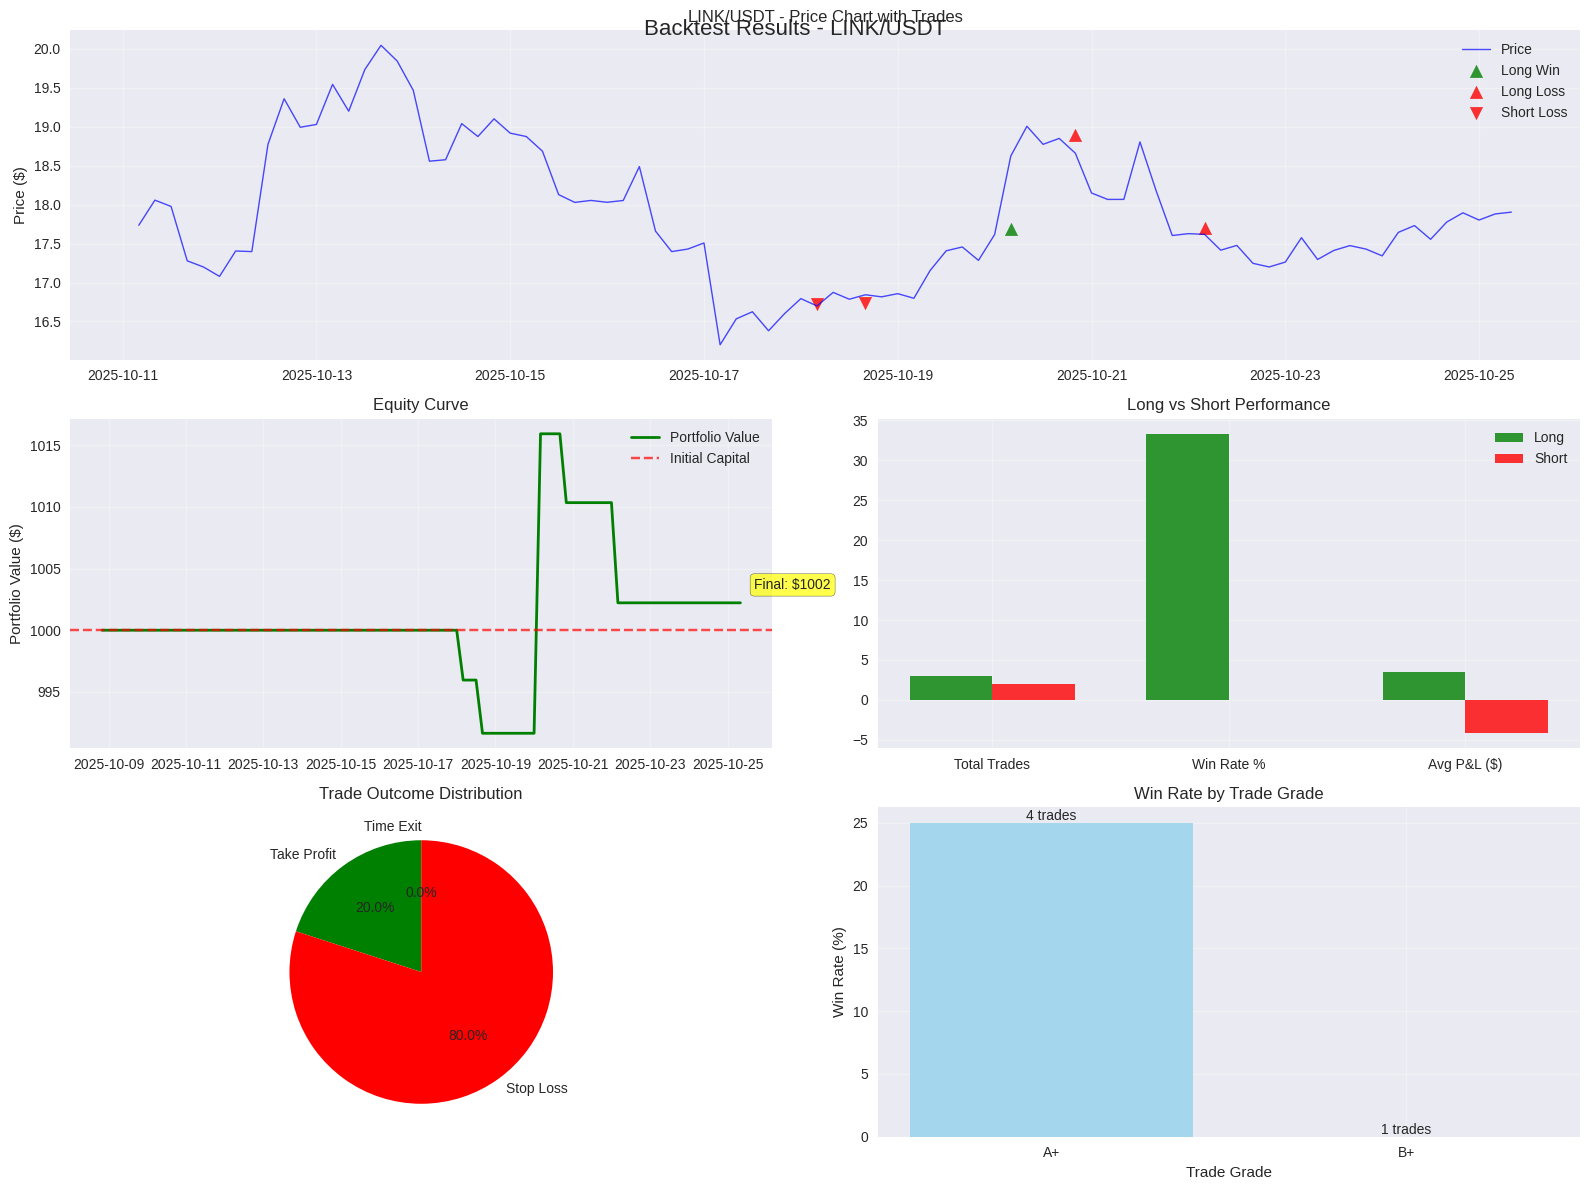


##################################################
ANALYZING 6/6: HNT/USDT
##################################################

🔬 BACKTESTING: HNT/USDT

📊 BACKTEST RESULTS: HNT/USDT
   • Period: 9 trades analyzed
   • Initial Capital: $1,000.00
   • Final Capital: $942.86
   • Total P&L: $-57.14 (-5.7%)

📈 PERFORMANCE METRICS:
   • Win Rate: 11.1%
   • Profit Factor: 0.30
   • Sharpe Ratio: -0.56
   • Max Drawdown: -8.0%
   • Avg P&L per Trade: $-6.35

🎯 LONG/SHORT BREAKDOWN:
   📈 LONG Trades: 3
     • Win Rate: 0.0%
     • Wins: 0 | Losses: 3
     • Total P&L: $-31.93
     • Avg P&L: $-10.64
   📉 SHORT Trades: 6
     • Win Rate: 16.7%
     • Wins: 1 | Losses: 5
     • Total P&L: $-25.21
     • Avg P&L: $-4.20

📊 OUTCOME DISTRIBUTION:
   • Take Profit: 1 trades
   • Stop Loss: 8 trades
   • Time Exit: 0 trades

⭐ GRADE PERFORMANCE:
   • A+: 1 trades, 0.0% win rate, $-5.47 avg
   • A: 3 trades, 0.0% win rate, $-12.77 avg
   • B+: 5 trades, 20.0% win rate, $-2.68 avg


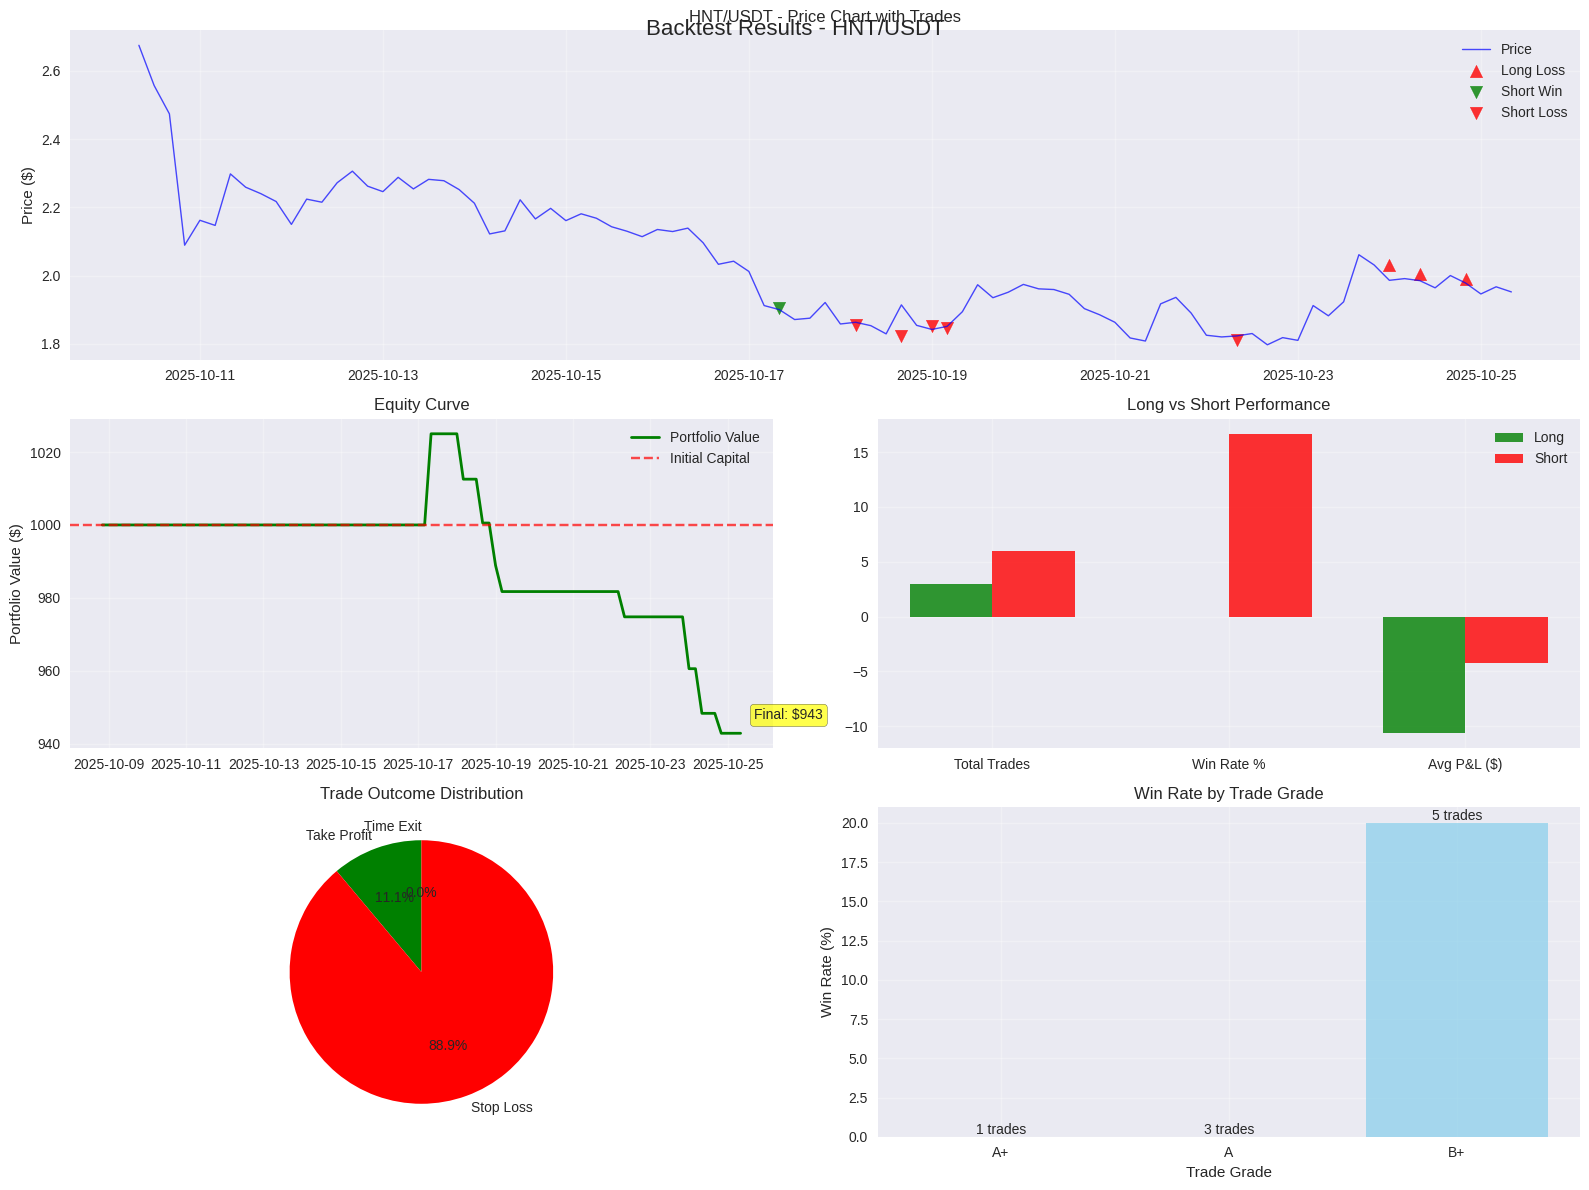

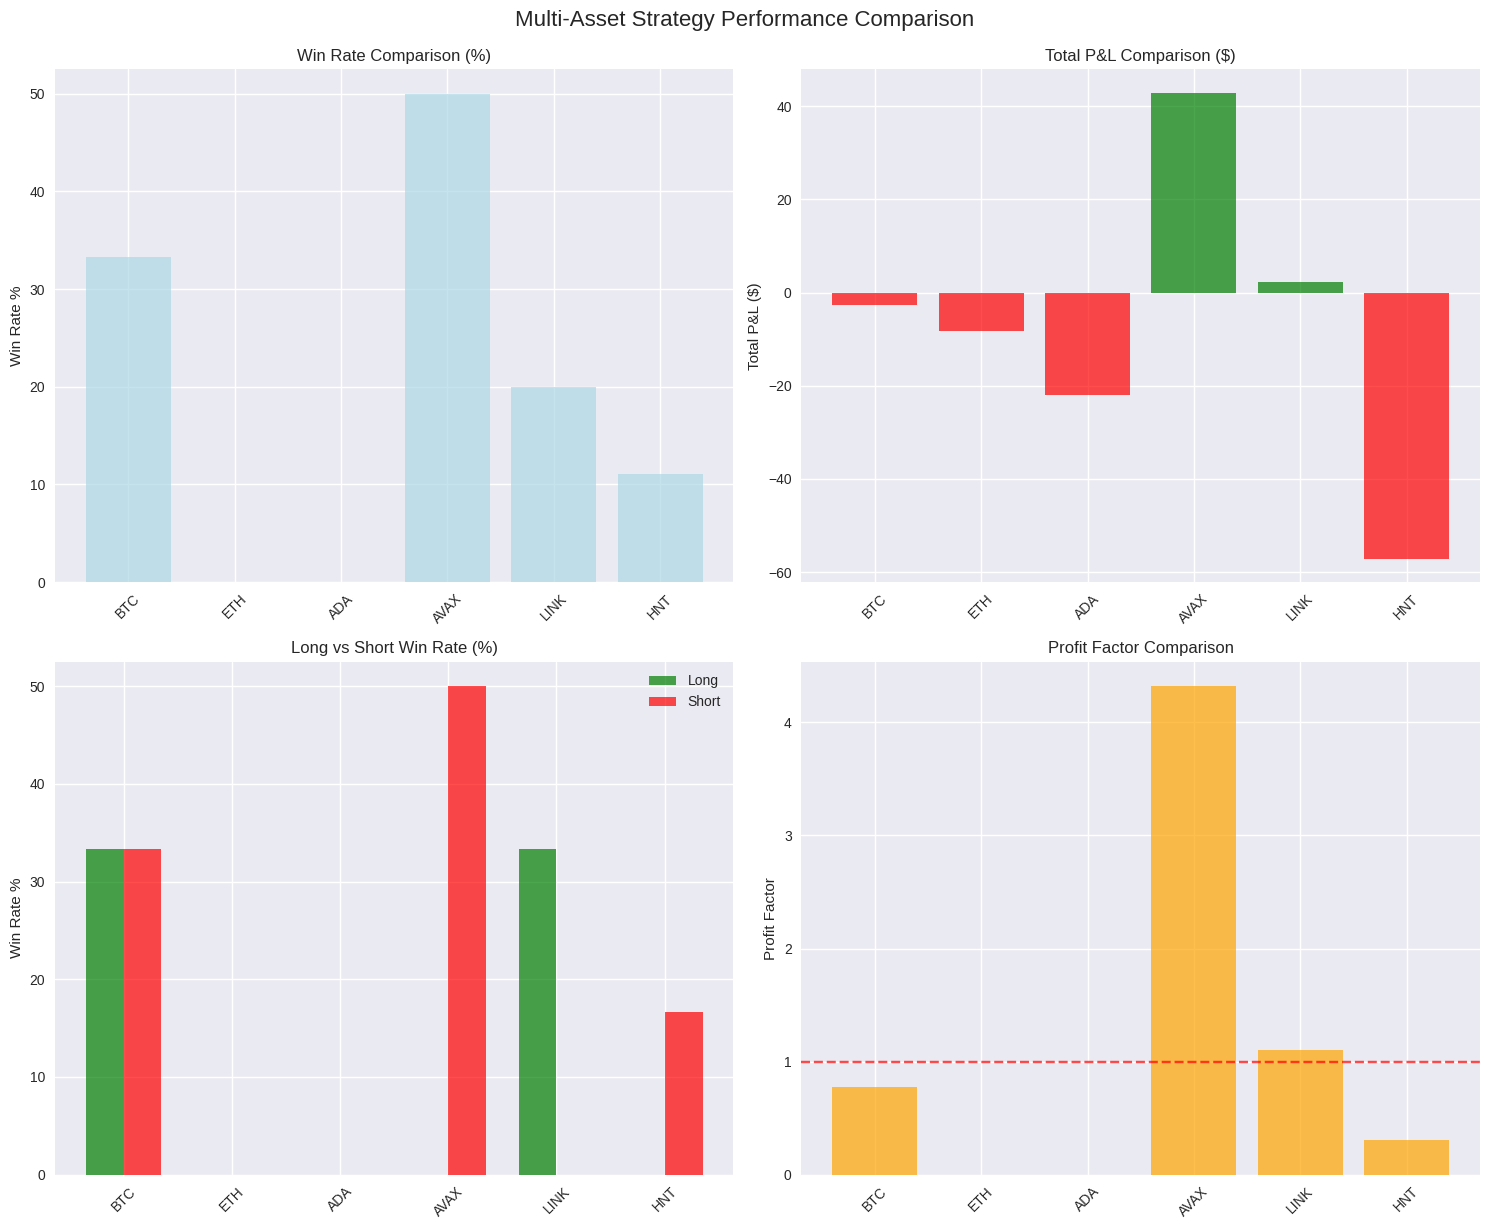


📊 COMPREHENSIVE MULTI-ASSET COMPARISON TABLE
Symbol   Trades Win Rate Total P&L    Profit Factor Sharpe   Drawdown   Long WR  Short WR
----------------------------------------------------------------------------------------------------
BTC      6      33.3   % $-3         0.78        -0.12   -0.9     % 33.3   % 33.3   %
ETH      2      0.0    % $-8         0.00        -4.90   -0.8     % 0.0    % 0.0    %
ADA      5      0.0    % $-22        0.00        -3.25   -2.2     % 0.0    % 0.0    %
AVAX     6      50.0   % $43         4.32        0.61    -0.9     % 0.0    % 50.0   %
LINK     5      20.0   % $2          1.10        0.04    -1.3     % 33.3   % 0.0    %
HNT      9      11.1   % $-57        0.30        -0.56   -8.0     % 0.0    % 16.7   %


In [3]:
import ccxt
import pandas as pd
import numpy as np
import pandas_ta as ta
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class BacktestTradingStrategy:
    def __init__(self, initial_capital=1000):
        self.initial_capital = initial_capital
        self.data = {}
        self.results = {}
        self.all_trades = {}

    def fetch_historical_data(self, symbol='BTC/USDT', timeframe='4h', limit=1000):
        """Fetch historical OHLCV data for backtesting"""
        try:
            exchange = ccxt.kucoin()
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            return df
        except Exception as e:
            print(f"Error fetching historical data for {symbol}: {e}")
            return None

    def calculate_4h_indicators(self, df):
        """Calculate 4H indicators for trend direction"""
        df = df.copy()

        try:
            # Volume-based Trend Indicators
            df['VWMA_20'] = ta.vwma(df['close'], df['volume'], length=20)
            df['VWMA_50'] = ta.vwma(df['close'], df['volume'], length=50)

            # Volume Momentum
            df['OBV'] = ta.obv(df['close'], df['volume'])
            df['OBV_EMA_20'] = ta.ema(df['OBV'], length=20)

            # Chaikin Money Flow
            df['CMF_20'] = ta.cmf(df['high'], df['low'], df['close'], df['volume'], length=20)

            # Volatility-adjusted Trend
            df['ATR_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)
            df['EMA_20'] = ta.ema(df['close'], length=20)
            df['EMA_50'] = ta.ema(df['close'], length=50)

            # Supertrend
            supertrend = ta.supertrend(df['high'], df['low'], df['close'], length=10, multiplier=3)
            if not supertrend.empty:
                supertrend_cols = supertrend.columns
                for col in supertrend_cols:
                    if 'SUPERT' in col and 'd' not in col:
                        df['Supertrend'] = supertrend[col]
                    elif 'SUPERTd' in col:
                        df['Supertrend_Direction'] = supertrend[col]
            else:
                df['Supertrend'] = df['EMA_20']
                df['Supertrend_Direction'] = np.where(df['close'] > df['EMA_20'], 1, -1)

            # Trend Strength
            adx_data = ta.adx(df['high'], df['low'], df['close'], length=14)
            if not adx_data.empty:
                df['ADX'] = adx_data['ADX_14']
            else:
                df['ADX'] = 25

            # Volume-based confirmation
            df['Volume_SMA_20'] = ta.sma(df['volume'], length=20)
            df['Volume_Ratio'] = df['volume'] / df['Volume_SMA_20']

            df = df.fillna(method='bfill').fillna(method='ffill')

        except Exception as e:
            print(f"Error calculating 4H indicators: {e}")
            df['EMA_20'] = ta.ema(df['close'], length=20)
            df['EMA_50'] = ta.ema(df['close'], length=50)
            df['VWMA_20'] = df['EMA_20']
            df['VWMA_50'] = df['EMA_50']
            df['Supertrend_Direction'] = np.where(df['close'] > df['EMA_20'], 1, -1)
            df['ADX'] = 25
            df['Volume_Ratio'] = 1.0

        return df

    def calculate_15m_indicators(self, df):
        """Calculate 15M indicators for precise entries"""
        df = df.copy()

        try:
            # Momentum Indicators
            df['RSI_14'] = ta.rsi(df['close'], length=14)

            # MACD for momentum
            macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
            if not macd.empty:
                df['MACD'] = macd['MACD_12_26_9']
                df['MACD_signal'] = macd['MACDs_12_26_9']
                df['MACD_histogram'] = macd['MACDh_12_26_9']
            else:
                df['MACD'] = 0
                df['MACD_signal'] = 0
                df['MACD_histogram'] = 0

            # Volatility for stops
            df['ATR_5'] = ta.atr(df['high'], df['low'], df['close'], length=5)

            # Volume confirmation
            df['Volume_EMA_10'] = ta.ema(df['volume'], length=10)
            df['Volume_Spike'] = df['volume'] > (df['Volume_EMA_10'] * 1.2)

            # Price action
            df['EMA_9'] = ta.ema(df['close'], length=9)
            df['EMA_21'] = ta.ema(df['close'], length=21)

            df = df.fillna(method='bfill').fillna(method='ffill')

        except Exception as e:
            print(f"Error calculating 15M indicators: {e}")
            df['RSI_14'] = 50
            df['MACD'] = 0
            df['MACD_signal'] = 0
            df['MACD_histogram'] = 0
            df['ATR_5'] = df['close'] * 0.01
            df['Volume_Spike'] = False
            df['EMA_9'] = df['close']
            df['EMA_21'] = df['close']

        return df

    def identify_4h_trend(self, df_4h, index):
        """Identify 4H Trend Direction at specific index"""
        if index < 2:
            return 'neutral'

        try:
            current = df_4h.iloc[index]
            prev = df_4h.iloc[index-1]

            # Volume-Weighted Bullish Trend
            volume_bullish = (
                current['VWMA_20'] > current['VWMA_50'] and
                current['OBV'] > current['OBV_EMA_20'] and
                current['CMF_20'] > 0 and
                current['Volume_Ratio'] > 0.8
            )

            # Volume-Weighted Bearish Trend
            volume_bearish = (
                current['VWMA_20'] < current['VWMA_50'] and
                current['OBV'] < current['OBV_EMA_20'] and
                current['CMF_20'] < 0 and
                current['Volume_Ratio'] > 0.8
            )

            # Trend Strength Filter
            strong_trend = current['ADX'] > 25
            moderate_trend = current['ADX'] > 20

            # Supertrend confirmation
            supertrend_bullish = current.get('Supertrend_Direction', 0) == 1
            supertrend_bearish = current.get('Supertrend_Direction', 0) == -1

            # Final Trend Classification
            bullish_conditions = [
                volume_bullish,
                supertrend_bullish,
                moderate_trend,
                current['close'] > current['VWMA_20']
            ]

            bearish_conditions = [
                volume_bearish,
                supertrend_bearish,
                moderate_trend,
                current['close'] < current['VWMA_20']
            ]

            bullish_score = sum(bullish_conditions)
            bearish_score = sum(bearish_conditions)

            if bullish_score >= 3 and strong_trend:
                return 'strong_bullish'
            elif bullish_score >= 3:
                return 'bullish'
            elif bearish_score >= 3 and strong_trend:
                return 'strong_bearish'
            elif bearish_score >= 3:
                return 'bearish'
            else:
                return 'neutral'

        except Exception as e:
            return 'neutral'

    def get_15m_entry_signals(self, df_15m, trend_direction, index):
        """Find 15M Entry Signals at specific index"""
        if index < 2:
            return [], []

        try:
            current = df_15m.iloc[index]
            prev = df_15m.iloc[index-1]

            signals = []
            trade_details = []

            # Dynamic RSI levels based on trend strength
            if 'strong' in trend_direction:
                rsi_oversold = 45
                rsi_overbought = 75
            else:
                rsi_oversold = 35
                rsi_overbought = 65

            if trend_direction in ['bullish', 'strong_bullish']:
                # Long Entry Conditions
                long_conditions = [
                    current['RSI_14'] > rsi_oversold,
                    current['RSI_14'] < rsi_overbought,
                    current['MACD'] > current['MACD_signal'],
                    current['MACD_histogram'] > prev['MACD_histogram'],
                    current['close'] > current['EMA_9'],
                    current['EMA_9'] > current['EMA_21'],
                    current.get('Volume_Spike', False),
                    current['RSI_14'] > 50 or trend_direction == 'strong_bullish'
                ]

                conditions_met = sum(long_conditions)
                min_conditions = 7 if trend_direction == 'strong_bullish' else 6

                if conditions_met >= min_conditions:
                    atr = current.get('ATR_5', current['close'] * 0.01)
                    entry_price = current['close']

                    stop_multiplier = 1.0 if 'strong' in trend_direction else 1.5
                    tp_multiplier = 3.0 if 'strong' in trend_direction else 2.5

                    stop_loss = entry_price - (stop_multiplier * atr)
                    take_profit = entry_price + (tp_multiplier * atr)

                    grade = self.grade_setup(conditions_met, len(long_conditions), trend_direction)

                    signals.append('LONG')
                    trade_details.append({
                        'type': 'LONG',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'grade': grade,
                        'conditions_met': conditions_met,
                        'risk_reward': tp_multiplier / stop_multiplier
                    })

            elif trend_direction in ['bearish', 'strong_bearish']:
                # Short Entry Conditions
                short_conditions = [
                    current['RSI_14'] < rsi_overbought,
                    current['RSI_14'] > rsi_oversold,
                    current['MACD'] < current['MACD_signal'],
                    current['MACD_histogram'] < prev['MACD_histogram'],
                    current['close'] < current['EMA_9'],
                    current['EMA_9'] < current['EMA_21'],
                    current.get('Volume_Spike', False),
                    current['RSI_14'] < 50 or trend_direction == 'strong_bearish'
                ]

                conditions_met = sum(short_conditions)
                min_conditions = 7 if trend_direction == 'strong_bearish' else 6

                if conditions_met >= min_conditions:
                    atr = current.get('ATR_5', current['close'] * 0.01)
                    entry_price = current['close']

                    stop_multiplier = 1.0 if 'strong' in trend_direction else 1.5
                    tp_multiplier = 3.0 if 'strong' in trend_direction else 2.5

                    stop_loss = entry_price + (stop_multiplier * atr)
                    take_profit = entry_price - (tp_multiplier * atr)

                    grade = self.grade_setup(conditions_met, len(short_conditions), trend_direction)

                    signals.append('SHORT')
                    trade_details.append({
                        'type': 'SHORT',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'grade': grade,
                        'conditions_met': conditions_met,
                        'risk_reward': tp_multiplier / stop_multiplier
                    })

            return signals, trade_details

        except Exception as e:
            return [], []

    def grade_setup(self, conditions_met, total_conditions, trend):
        """Grade trade setup from A+ to C"""
        try:
            score = (conditions_met / total_conditions) * 100
            if 'strong' in trend:
                score += 10

            if score >= 90:
                return 'A+'
            elif score >= 80:
                return 'A'
            elif score >= 70:
                return 'B+'
            elif score >= 60:
                return 'B'
            elif score >= 50:
                return 'C+'
            else:
                return 'C'
        except:
            return 'C'

    def calculate_position_size(self, capital, entry_price, stop_loss, volatility_ratio=1.0):
        """Calculate position size with volatility adjustment"""
        try:
            risk_per_trade = 0.02
            risk_amount = capital * risk_per_trade
            volatility_adjustment = min(1.0, 1.0 / max(volatility_ratio, 0.1))
            adjusted_risk = risk_amount * volatility_adjustment

            price_diff = abs(entry_price - stop_loss)
            if price_diff == 0:
                return 0

            position_size = adjusted_risk / price_diff
            return min(position_size, capital / entry_price * 0.95)
        except:
            return 0

    def run_backtest(self, symbol='BTC/USDT', periods=100, plot_results=True):
        """Run complete backtest"""
        print(f"\n{'='*80}")
        print(f"🔬 BACKTESTING: {symbol}")
        print(f"{'='*80}")

        # Fetch data
        df_4h = self.fetch_historical_data(symbol, '4h', periods * 2)
        df_15m = self.fetch_historical_data(symbol, '15m', periods * 24)

        if df_4h is None or df_15m is None:
            print(f"❌ Could not fetch data for {symbol}")
            return None, None

        # Calculate indicators
        df_4h = self.calculate_4h_indicators(df_4h)
        df_15m = self.calculate_15m_indicators(df_15m)

        # Align timeframes
        trades = []
        capital = self.initial_capital
        portfolio_value = [capital]
        equity_timeline = [{'timestamp': df_4h.index[0], 'equity': capital}]

        # Skip warm-up period
        start_idx = max(len(df_4h) - periods, 0)

        for i in range(start_idx, len(df_4h)):
            current_4h_time = df_4h.index[i]

            # Find corresponding 15m data
            mask_15m = (df_15m.index >= current_4h_time - timedelta(hours=4)) & (df_15m.index <= current_4h_time)
            relevant_15m = df_15m[mask_15m]

            if len(relevant_15m) == 0:
                continue

            # Use the last 15m candle of the 4h period
            last_15m_idx = relevant_15m.index[-1]
            last_15m_data_idx = df_15m.index.get_loc(last_15m_idx)

            # Get trend and signals
            trend = self.identify_4h_trend(df_4h, i)
            signals, trade_details = self.get_15m_entry_signals(df_15m, trend, last_15m_data_idx)

            if signals and trade_details:
                trade = trade_details[0]
                entry_price = trade['entry_price']
                stop_loss = trade['stop_loss']
                take_profit = trade['take_profit']

                # Calculate position size
                volatility_ratio = df_4h.iloc[i].get('ATR_14', 0) / max(df_4h.iloc[i]['close'], 1)
                position_size = self.calculate_position_size(capital, entry_price, stop_loss, volatility_ratio)

                if position_size > 0:
                    # Simulate trade outcome
                    outcome = self.simulate_trade_outcome(
                        df_15m, last_15m_data_idx, trade['type'],
                        entry_price, stop_loss, take_profit, position_size
                    )

                    # Update capital
                    capital += outcome['pnl']
                    portfolio_value.append(capital)
                    equity_timeline.append({'timestamp': current_4h_time, 'equity': capital})

                    trades.append({
                        'symbol': symbol,
                        'timestamp': current_4h_time,
                        'type': trade['type'],
                        'entry_price': entry_price,
                        'exit_price': outcome['exit_price'],
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'position_size': position_size,
                        'pnl': outcome['pnl'],
                        'pnl_pct': outcome['pnl_pct'],
                        'outcome': outcome['outcome'],
                        'grade': trade['grade'],
                        'conditions_met': trade['conditions_met'],
                        'duration': outcome['duration'],
                        'trend': trend
                    })
            else:
                # Record equity even when no trade
                equity_timeline.append({'timestamp': current_4h_time, 'equity': capital})

        # Calculate performance metrics
        results = self.calculate_performance_metrics(trades, portfolio_value, equity_timeline)
        self.results[symbol] = results
        self.all_trades[symbol] = trades

        self.print_backtest_results(symbol, trades, results)

        if plot_results and trades:
            self.plot_backtest_results(symbol, trades, df_4h, equity_timeline, results)

        return trades, results

    def simulate_trade_outcome(self, df_15m, entry_idx, trade_type, entry_price, stop_loss, take_profit, position_size):
        """Simulate individual trade outcome"""
        max_lookahead = 96  # Maximum 24 hours (96 * 15min)

        for i in range(1, min(max_lookahead, len(df_15m) - entry_idx)):
            current_idx = entry_idx + i
            current_data = df_15m.iloc[current_idx]
            current_low = current_data['low']
            current_high = current_data['high']
            current_close = current_data['close']

            if trade_type == 'LONG':
                # Check for stop loss hit
                if current_low <= stop_loss:
                    return {
                        'exit_price': stop_loss,
                        'pnl': (stop_loss - entry_price) * position_size,
                        'pnl_pct': (stop_loss - entry_price) / entry_price * 100,
                        'outcome': 'STOP_LOSS',
                        'duration': i * 15  # minutes
                    }
                # Check for take profit hit
                elif current_high >= take_profit:
                    return {
                        'exit_price': take_profit,
                        'pnl': (take_profit - entry_price) * position_size,
                        'pnl_pct': (take_profit - entry_price) / entry_price * 100,
                        'outcome': 'TAKE_PROFIT',
                        'duration': i * 15
                    }
            else:  # SHORT
                # Check for stop loss hit
                if current_high >= stop_loss:
                    return {
                        'exit_price': stop_loss,
                        'pnl': (entry_price - stop_loss) * position_size,
                        'pnl_pct': (entry_price - stop_loss) / entry_price * 100,
                        'outcome': 'STOP_LOSS',
                        'duration': i * 15
                    }
                # Check for take profit hit
                elif current_low <= take_profit:
                    return {
                        'exit_price': take_profit,
                        'pnl': (entry_price - take_profit) * position_size,
                        'pnl_pct': (entry_price - take_profit) / entry_price * 100,
                        'outcome': 'TAKE_PROFIT',
                        'duration': i * 15
                    }

        # If no exit condition met, exit at last price
        last_price = df_15m.iloc[entry_idx + max_lookahead - 1]['close'] if entry_idx + max_lookahead < len(df_15m) else df_15m.iloc[-1]['close']
        if trade_type == 'LONG':
            pnl = (last_price - entry_price) * position_size
            pnl_pct = (last_price - entry_price) / entry_price * 100
        else:
            pnl = (entry_price - last_price) * position_size
            pnl_pct = (entry_price - last_price) / entry_price * 100

        return {
            'exit_price': last_price,
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'outcome': 'TIME_EXIT',
            'duration': max_lookahead * 15
        }

    def calculate_performance_metrics(self, trades, portfolio_value, equity_timeline):
        """Calculate comprehensive performance metrics"""
        if not trades:
            return {
                'total_trades': 0,
                'win_rate': 0,
                'total_pnl': 0,
                'avg_pnl': 0,
                'profit_factor': 0,
                'max_drawdown': 0,
                'sharpe_ratio': 0,
                'long_short_stats': {},
                'monthly_returns': [],
                'equity_timeline': equity_timeline
            }

        df_trades = pd.DataFrame(trades)

        # Basic metrics
        total_trades = len(trades)
        winning_trades = len([t for t in trades if t['pnl'] > 0])
        win_rate = winning_trades / total_trades * 100

        total_pnl = sum(t['pnl'] for t in trades)
        avg_pnl = total_pnl / total_trades

        # Profit factor
        gross_profit = sum(t['pnl'] for t in trades if t['pnl'] > 0)
        gross_loss = abs(sum(t['pnl'] for t in trades if t['pnl'] < 0))
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

        # Max drawdown
        portfolio_series = pd.Series(portfolio_value)
        rolling_max = portfolio_series.expanding().max()
        drawdown = (portfolio_series - rolling_max) / rolling_max * 100
        max_drawdown = drawdown.min()

        # Sharpe ratio
        returns = [t['pnl_pct'] for t in trades]
        avg_return = np.mean(returns)
        std_return = np.std(returns)
        sharpe_ratio = avg_return / std_return if std_return > 0 else 0

        # Long/Short performance
        long_trades = [t for t in trades if t['type'] == 'LONG']
        short_trades = [t for t in trades if t['type'] == 'SHORT']

        long_win_rate = len([t for t in long_trades if t['pnl'] > 0]) / len(long_trades) * 100 if long_trades else 0
        short_win_rate = len([t for t in short_trades if t['pnl'] > 0]) / len(short_trades) * 100 if short_trades else 0

        long_short_stats = {
            'long': {
                'total': len(long_trades),
                'winning': len([t for t in long_trades if t['pnl'] > 0]),
                'losing': len([t for t in long_trades if t['pnl'] < 0]),
                'win_rate': long_win_rate,
                'total_pnl': sum(t['pnl'] for t in long_trades),
                'avg_pnl': sum(t['pnl'] for t in long_trades) / len(long_trades) if long_trades else 0
            },
            'short': {
                'total': len(short_trades),
                'winning': len([t for t in short_trades if t['pnl'] > 0]),
                'losing': len([t for t in short_trades if t['pnl'] < 0]),
                'win_rate': short_win_rate,
                'total_pnl': sum(t['pnl'] for t in short_trades),
                'avg_pnl': sum(t['pnl'] for t in short_trades) / len(short_trades) if short_trades else 0
            }
        }

        # Grade performance
        grade_performance = {}
        for grade in ['A+', 'A', 'B+', 'B', 'C+', 'C']:
            grade_trades = [t for t in trades if t['grade'] == grade]
            if grade_trades:
                grade_win_rate = len([t for t in grade_trades if t['pnl'] > 0]) / len(grade_trades) * 100
                grade_avg_pnl = sum(t['pnl'] for t in grade_trades) / len(grade_trades)
                grade_performance[grade] = {
                    'count': len(grade_trades),
                    'win_rate': grade_win_rate,
                    'avg_pnl': grade_avg_pnl
                }

        return {
            'total_trades': total_trades,
            'win_rate': win_rate,
            'total_pnl': total_pnl,
            'avg_pnl': avg_pnl,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'long_short_stats': long_short_stats,
            'grade_performance': grade_performance,
            'outcomes': {
                'STOP_LOSS': len([t for t in trades if t['outcome'] == 'STOP_LOSS']),
                'TAKE_PROFIT': len([t for t in trades if t['outcome'] == 'TAKE_PROFIT']),
                'TIME_EXIT': len([t for t in trades if t['outcome'] == 'TIME_EXIT'])
            },
            'equity_timeline': equity_timeline
        }

    def print_backtest_results(self, symbol, trades, results):
        """Print comprehensive backtest results"""
        ls_stats = results['long_short_stats']

        print(f"\n📊 BACKTEST RESULTS: {symbol}")
        print(f"   • Period: {len(trades)} trades analyzed")
        print(f"   • Initial Capital: ${self.initial_capital:,.2f}")
        print(f"   • Final Capital: ${self.initial_capital + results['total_pnl']:,.2f}")
        print(f"   • Total P&L: ${results['total_pnl']:,.2f} ({results['total_pnl']/self.initial_capital*100:.1f}%)")

        print(f"\n📈 PERFORMANCE METRICS:")
        print(f"   • Win Rate: {results['win_rate']:.1f}%")
        print(f"   • Profit Factor: {results['profit_factor']:.2f}")
        print(f"   • Sharpe Ratio: {results['sharpe_ratio']:.2f}")
        print(f"   • Max Drawdown: {results['max_drawdown']:.1f}%")
        print(f"   • Avg P&L per Trade: ${results['avg_pnl']:.2f}")

        print(f"\n🎯 LONG/SHORT BREAKDOWN:")
        print(f"   📈 LONG Trades: {ls_stats['long']['total']}")
        print(f"     • Win Rate: {ls_stats['long']['win_rate']:.1f}%")
        print(f"     • Wins: {ls_stats['long']['winning']} | Losses: {ls_stats['long']['losing']}")
        print(f"     • Total P&L: ${ls_stats['long']['total_pnl']:.2f}")
        print(f"     • Avg P&L: ${ls_stats['long']['avg_pnl']:.2f}")

        print(f"   📉 SHORT Trades: {ls_stats['short']['total']}")
        print(f"     • Win Rate: {ls_stats['short']['win_rate']:.1f}%")
        print(f"     • Wins: {ls_stats['short']['winning']} | Losses: {ls_stats['short']['losing']}")
        print(f"     • Total P&L: ${ls_stats['short']['total_pnl']:.2f}")
        print(f"     • Avg P&L: ${ls_stats['short']['avg_pnl']:.2f}")

        print(f"\n📊 OUTCOME DISTRIBUTION:")
        print(f"   • Take Profit: {results['outcomes']['TAKE_PROFIT']} trades")
        print(f"   • Stop Loss: {results['outcomes']['STOP_LOSS']} trades")
        print(f"   • Time Exit: {results['outcomes']['TIME_EXIT']} trades")

        print(f"\n⭐ GRADE PERFORMANCE:")
        for grade, perf in results['grade_performance'].items():
            if perf['count'] > 0:
                print(f"   • {grade}: {perf['count']} trades, {perf['win_rate']:.1f}% win rate, ${perf['avg_pnl']:.2f} avg")

    def plot_backtest_results(self, symbol, trades, df_4h, equity_timeline, results):
        """Create comprehensive visualization of backtest results"""
        if not trades:
            print("No trades to plot")
            return

        # Create figure with subplots
        fig = plt.figure(figsize=(16, 12))
        gs = gridspec.GridSpec(3, 2, figure=fig)

        # Plot 1: Price and Trades
        ax1 = fig.add_subplot(gs[0, :])
        self._plot_price_trades(ax1, symbol, trades, df_4h)

        # Plot 2: Equity Curve
        ax2 = fig.add_subplot(gs[1, 0])
        self._plot_equity_curve(ax2, equity_timeline, results)

        # Plot 3: Long/Short Performance
        ax3 = fig.add_subplot(gs[1, 1])
        self._plot_long_short_stats(ax3, results['long_short_stats'])

        # Plot 4: Trade Outcomes
        ax4 = fig.add_subplot(gs[2, 0])
        self._plot_outcome_distribution(ax4, results['outcomes'])

        # Plot 5: Grade Performance
        ax5 = fig.add_subplot(gs[2, 1])
        self._plot_grade_performance(ax5, results['grade_performance'])

        plt.tight_layout()
        plt.suptitle(f'Backtest Results - {symbol}', fontsize=16, y=0.98)
        plt.show()

    def _plot_price_trades(self, ax, symbol, trades, df_4h):
        """Plot price chart with trade entries/exits"""
        # Get the period covered by trades
        trade_dates = [t['timestamp'] for t in trades]
        if not trade_dates:
            return

        start_date = min(trade_dates)
        end_date = max(trade_dates)

        # Filter price data to relevant period
        mask = (df_4h.index >= start_date - timedelta(days=7)) & (df_4h.index <= end_date + timedelta(days=7))
        plot_data = df_4h[mask]

        # Plot price
        ax.plot(plot_data.index, plot_data['close'], label='Price', linewidth=1, alpha=0.7, color='blue')

        # Plot trades
        long_wins = [t for t in trades if t['type'] == 'LONG' and t['pnl'] > 0]
        long_losses = [t for t in trades if t['type'] == 'LONG' and t['pnl'] <= 0]
        short_wins = [t for t in trades if t['type'] == 'SHORT' and t['pnl'] > 0]
        short_losses = [t for t in trades if t['type'] == 'SHORT' and t['pnl'] <= 0]

        if long_wins:
            ax.scatter([t['timestamp'] for t in long_wins], [t['entry_price'] for t in long_wins],
                      c='green', marker='^', s=80, label='Long Win', alpha=0.8)
        if long_losses:
            ax.scatter([t['timestamp'] for t in long_losses], [t['entry_price'] for t in long_losses],
                      c='red', marker='^', s=80, label='Long Loss', alpha=0.8)
        if short_wins:
            ax.scatter([t['timestamp'] for t in short_wins], [t['entry_price'] for t in short_wins],
                      c='green', marker='v', s=80, label='Short Win', alpha=0.8)
        if short_losses:
            ax.scatter([t['timestamp'] for t in short_losses], [t['entry_price'] for t in short_losses],
                      c='red', marker='v', s=80, label='Short Loss', alpha=0.8)

        ax.set_title(f'{symbol} - Price Chart with Trades')
        ax.set_ylabel('Price ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_equity_curve(self, ax, equity_timeline, results):
        """Plot equity curve"""
        if not equity_timeline:
            return

        dates = [e['timestamp'] for e in equity_timeline]
        equity = [e['equity'] for e in equity_timeline]

        ax.plot(dates, equity, linewidth=2, label='Portfolio Value', color='green')
        ax.axhline(y=self.initial_capital, color='red', linestyle='--', alpha=0.7, label='Initial Capital')

        # Add final value annotation
        final_equity = equity[-1]
        ax.annotate(f'Final: ${final_equity:.0f}',
                   xy=(dates[-1], final_equity),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

        ax.set_title('Equity Curve')
        ax.set_ylabel('Portfolio Value ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_long_short_stats(self, ax, ls_stats):
        """Plot long/short performance comparison"""
        categories = ['Total Trades', 'Win Rate %', 'Avg P&L ($)']
        long_values = [
            ls_stats['long']['total'],
            ls_stats['long']['win_rate'],
            ls_stats['long']['avg_pnl']
        ]
        short_values = [
            ls_stats['short']['total'],
            ls_stats['short']['win_rate'],
            ls_stats['short']['avg_pnl']
        ]

        x = np.arange(len(categories))
        width = 0.35

        ax.bar(x - width/2, long_values, width, label='Long', alpha=0.8, color='green')
        ax.bar(x + width/2, short_values, width, label='Short', alpha=0.8, color='red')

        ax.set_title('Long vs Short Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_outcome_distribution(self, ax, outcomes):
        """Plot trade outcome distribution"""
        labels = ['Take Profit', 'Stop Loss', 'Time Exit']
        values = [outcomes['TAKE_PROFIT'], outcomes['STOP_LOSS'], outcomes['TIME_EXIT']]
        colors = ['green', 'red', 'orange']

        ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax.set_title('Trade Outcome Distribution')

    def _plot_grade_performance(self, ax, grade_performance):
        """Plot performance by trade grade"""
        if not grade_performance:
            return

        grades = list(grade_performance.keys())
        win_rates = [grade_performance[g]['win_rate'] for g in grades]
        counts = [grade_performance[g]['count'] for g in grades]

        bars = ax.bar(grades, win_rates, color='skyblue', alpha=0.7)
        ax.set_title('Win Rate by Trade Grade')
        ax.set_ylabel('Win Rate (%)')
        ax.set_xlabel('Trade Grade')

        # Add count labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{count} trades', ha='center', va='bottom')

        ax.grid(True, alpha=0.3)

    def plot_comparison_chart(self, symbols):
        """Create comparison chart for all assets"""
        if not self.results:
            print("No results to compare")
            return

        # Prepare data for comparison
        comparison_data = []
        for symbol in symbols:
            if symbol in self.results:
                results = self.results[symbol]
                comparison_data.append({
                    'Symbol': symbol.replace('/USDT', ''),
                    'Total Trades': results['total_trades'],
                    'Win Rate': results['win_rate'],
                    'Total P&L': results['total_pnl'],
                    'Profit Factor': results['profit_factor'],
                    'Sharpe Ratio': results['sharpe_ratio'],
                    'Max Drawdown': results['max_drawdown'],
                    'Long Win Rate': results['long_short_stats']['long']['win_rate'],
                    'Short Win Rate': results['long_short_stats']['short']['win_rate']
                })

        if not comparison_data:
            return

        df_comparison = pd.DataFrame(comparison_data)

        # Create comparison visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Win Rate Comparison
        axes[0, 0].bar(df_comparison['Symbol'], df_comparison['Win Rate'], color='lightblue', alpha=0.7)
        axes[0, 0].set_title('Win Rate Comparison (%)')
        axes[0, 0].set_ylabel('Win Rate %')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Plot 2: Total P&L Comparison
        colors = ['green' if x >= 0 else 'red' for x in df_comparison['Total P&L']]
        axes[0, 1].bar(df_comparison['Symbol'], df_comparison['Total P&L'], color=colors, alpha=0.7)
        axes[0, 1].set_title('Total P&L Comparison ($)')
        axes[0, 1].set_ylabel('Total P&L ($)')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Plot 3: Long vs Short Win Rate
        x = np.arange(len(df_comparison))
        width = 0.35
        axes[1, 0].bar(x - width/2, df_comparison['Long Win Rate'], width, label='Long', alpha=0.7, color='green')
        axes[1, 0].bar(x + width/2, df_comparison['Short Win Rate'], width, label='Short', alpha=0.7, color='red')
        axes[1, 0].set_title('Long vs Short Win Rate (%)')
        axes[1, 0].set_ylabel('Win Rate %')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(df_comparison['Symbol'], rotation=45)
        axes[1, 0].legend()

        # Plot 4: Profit Factor Comparison
        axes[1, 1].bar(df_comparison['Symbol'], df_comparison['Profit Factor'], color='orange', alpha=0.7)
        axes[1, 1].set_title('Profit Factor Comparison')
        axes[1, 1].set_ylabel('Profit Factor')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Break-even')

        plt.tight_layout()
        plt.suptitle('Multi-Asset Strategy Performance Comparison', fontsize=16, y=1.02)
        plt.show()

        # Print detailed comparison table
        print(f"\n{'='*100}")
        print("📊 COMPREHENSIVE MULTI-ASSET COMPARISON TABLE")
        print(f"{'='*100}")
        print(f"{'Symbol':<8} {'Trades':<6} {'Win Rate':<8} {'Total P&L':<12} {'Profit Factor':<12} {'Sharpe':<8} {'Drawdown':<10} {'Long WR':<8} {'Short WR':<8}")
        print(f"{'-'*100}")

        for _, row in df_comparison.iterrows():
            print(f"{row['Symbol']:<8} {row['Total Trades']:<6} {row['Win Rate']:<7.1f}% "
                  f"${row['Total P&L']:<10.0f} {row['Profit Factor']:<11.2f} {row['Sharpe Ratio']:<7.2f} "
                  f"{row['Max Drawdown']:<9.1f}% {row['Long Win Rate']:<7.1f}% {row['Short Win Rate']:<7.1f}%")

    def run_complete_analysis(self, symbols=None, periods=100):
        """Run complete analysis for all symbols with individual and comparison results"""
        if symbols is None:
            symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'AVAX/USDT', 'LINK/USDT', 'HNT/USDT']

        print("🚀 COMPLETE MULTI-ASSET BACKTEST ANALYSIS")
        print("=" * 100)
        print("STRATEGY: 4H Trend + 15M Entries | Volume + Volatility + RSI + MACD")
        print("=" * 100)

        # Run backtest for each symbol with individual plots
        for i, symbol in enumerate(symbols):
            print(f"\n{'#'*50}")
            print(f"ANALYZING {i+1}/{len(symbols)}: {symbol}")
            print(f"{'#'*50}")

            self.run_backtest(symbol, periods, plot_results=True)

        # Create comprehensive comparison
        self.plot_comparison_chart(symbols)

# Main execution
def main():
    backtester = BacktestTradingStrategy(initial_capital=1000)

    # Define symbols to analyze
    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'AVAX/USDT', 'LINK/USDT', 'HNT/USDT']

    # Run complete analysis for all assets
    backtester.run_complete_analysis(symbols, periods=50)

if __name__ == "__main__":
    main()